CELL 1: Initialization & Data Loading

In [1]:
# --- CELL 1 & 2: INITIALIZATION, FIX & DECOMPOSITION (FIXED SCALING) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Configuración de estilo
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (20, 16) # Tamaño grande y equilibrado

# 1. CARGA Y CORRECCIÓN
input_filename = 'train_256063_features_lean.csv'
print(f"Loading dataset: {input_filename}...")

Loading dataset: train_256063_features_lean.csv...


CELL 2: Classical Decomposition (Req 6.1)Splitting the series into yt = Trend + Seasonality + Residuals


[ANALYSIS] Performing Seasonal Decomposition...
Figura guardada exitosamente en: results/task6\seasonal_decomposition_analysis.png


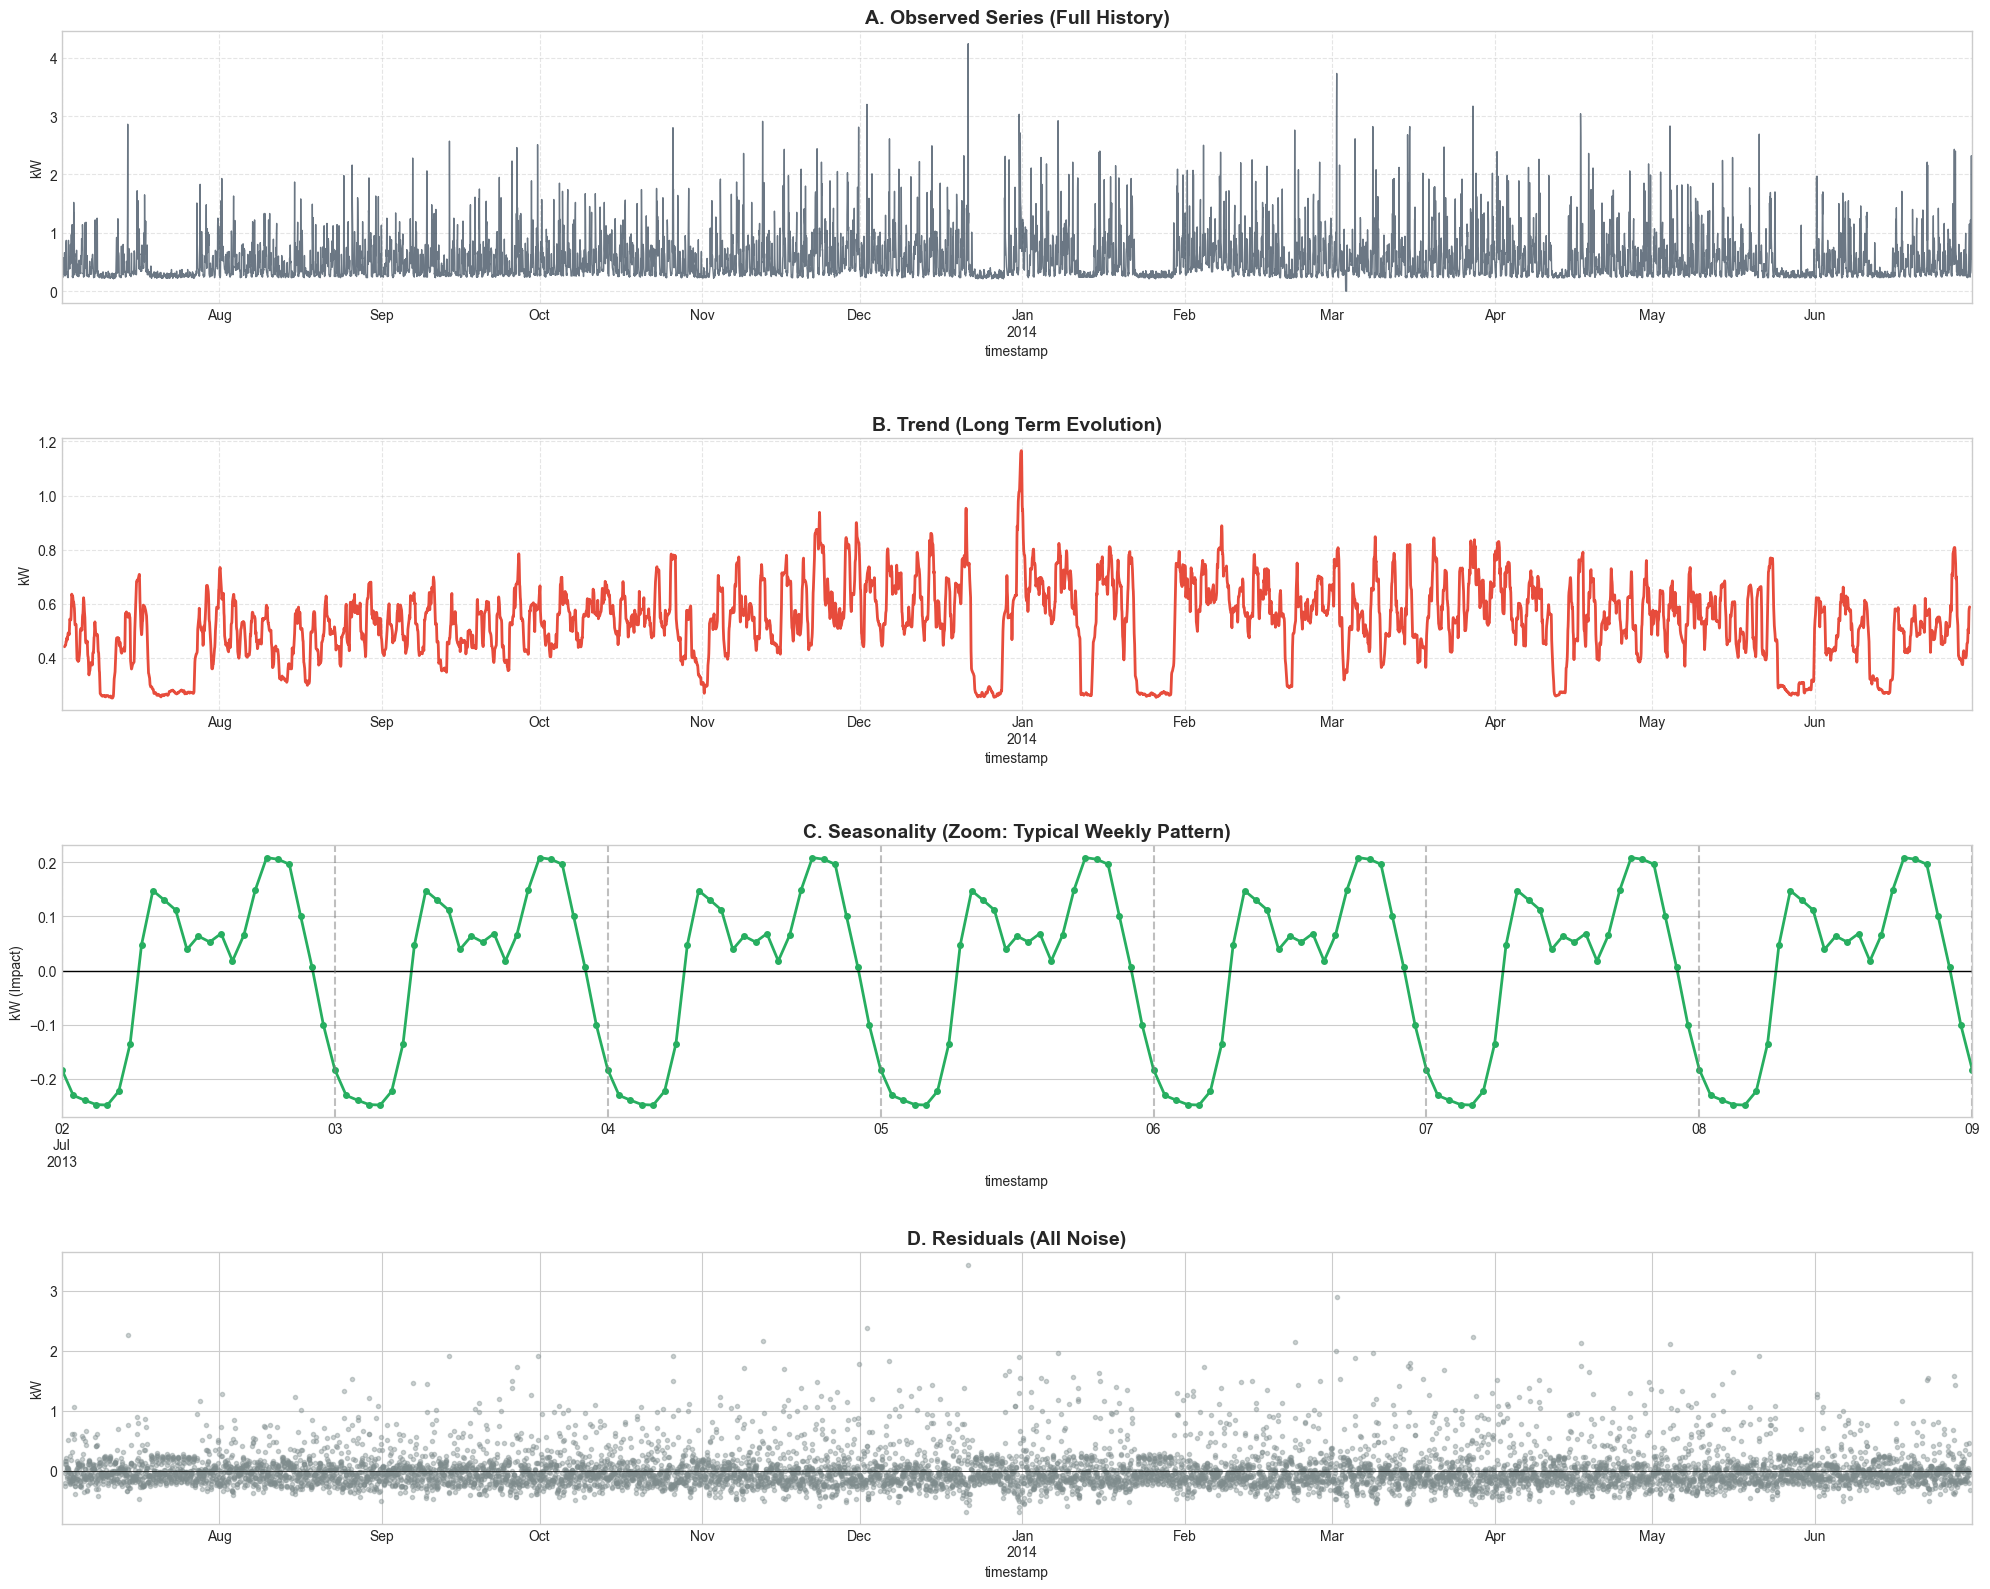

Gráfica generada correctamente.
   -> Nota: Gráficas A, B, D muestran años completos.
   -> Nota: Gráfica C muestra solo 1 semana (estirada) para ver el detalle horario.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import os  # Imported to handle directory creation

try:
    # 0. Load Data
    df = pd.read_csv(input_filename, index_col=0, parse_dates=True)
    df = df.asfreq('h')
    
    # 1. Fix Warning
    y = df['demand'].ffill()
    
    # 2. DESCOMPOSICIÓN
    print("\n[ANALYSIS] Performing Seasonal Decomposition...")
    decomp = seasonal_decompose(y, model='additive', period=24)

    # 3. VISUALIZACIÓN CORREGIDA (Ejes Independientes)
    fig, axes = plt.subplots(4, 1, figsize=(20, 16), sharex=False)

    # A. Observed
    y.plot(ax=axes[0], color='#2c3e50', alpha=0.7, linewidth=1)
    axes[0].set_title('A. Observed Series (Full History)', fontweight='bold', fontsize=14)
    axes[0].set_ylabel('kW')
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # B. Trend
    decomp.trend.plot(ax=axes[1], color='#e74c3c', linewidth=2)
    axes[1].set_title('B. Trend (Long Term Evolution)', fontweight='bold', fontsize=14)
    axes[1].set_ylabel('kW')
    axes[1].grid(True, linestyle='--', alpha=0.5)

    # C. Seasonality (ZOOM SEMANAL)
    zoom_start = y.index.min()
    zoom_end = zoom_start + pd.Timedelta(days=7)
    season_zoom = decomp.seasonal.loc[zoom_start:zoom_end]

    season_zoom.plot(ax=axes[2], color='#27ae60', linewidth=2, marker='o', markersize=4)
    axes[2].set_title('C. Seasonality (Zoom: Typical Weekly Pattern)', fontweight='bold', fontsize=14)
    axes[2].set_ylabel('kW (Impact)')
    axes[2].axhline(0, color='black', linewidth=1)
    
    for day in pd.date_range(start=zoom_start, end=zoom_end, freq='D'):
        axes[2].axvline(day, color='gray', linestyle='--', alpha=0.5)

    # D. Residuals
    decomp.resid.plot(ax=axes[3], color='#7f8c8d', linestyle='None', marker='.', alpha=0.4)
    axes[3].set_title('D. Residuals (All Noise)', fontweight='bold', fontsize=14)
    axes[3].set_ylabel('kW')
    axes[3].axhline(0, color='black', linewidth=0.5)

    plt.tight_layout(h_pad=3.0) 

    # --- SAVE LOGIC START ---
    output_dir = 'results/task6'
    
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define filename
    filename = 'seasonal_decomposition_analysis.png'
    save_path = os.path.join(output_dir, filename)
    
    # Save the figure (Must be done BEFORE plt.show())
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figura guardada exitosamente en: {save_path}")
    # --- SAVE LOGIC END ---

    plt.show()

    print("Gráfica generada correctamente.")
    print("   -> Nota: Gráficas A, B, D muestran años completos.")
    print("   -> Nota: Gráfica C muestra solo 1 semana (estirada) para ver el detalle horario.")
    
except Exception as e:
    print(f"Error: {e}")

CELL 3: Seasonality Strength Analysis (Req 6.2)
Answering "When is the seasonal effect strongest?". We calculate the daily amplitude per month.


[ANALYSIS] Identifying months with strongest seasonal impact...


C:\Users\pablo\AppData\Local\Temp\ipykernel_21028\899361481.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_seasonality.index, y=monthly_seasonality.values, palette='magma')


Figura guardada exitosamente en: results/task6\seasonal_strength_by_month.png


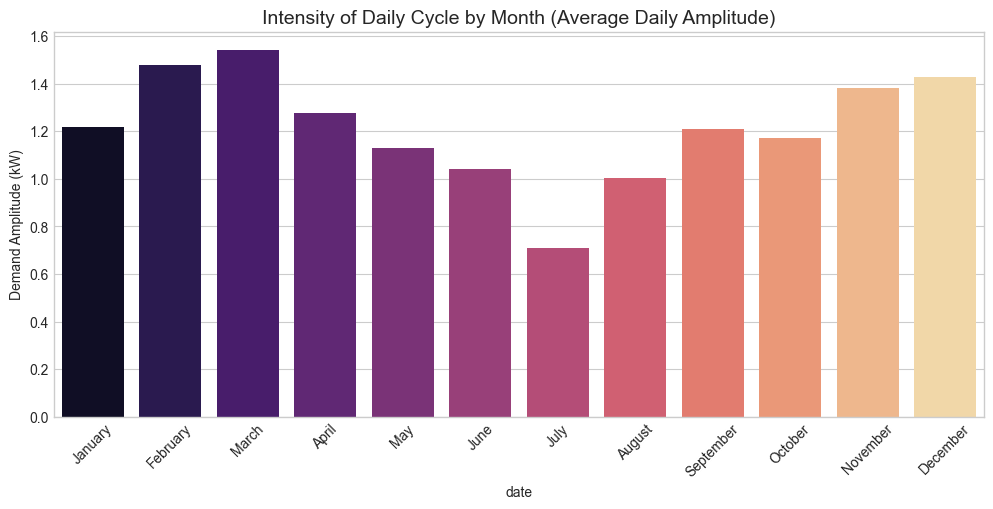

The seasonal effect (daily cycle) is strongest in: **March**.
   -> Probable Reason: Intensive use of HVAC (Heating/AC) creating large Day vs Night differences.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os # Necesario para crear carpetas

# --- CELL 3: SEASONALITY STRENGTH ANALYSIS (REQ 6.2) ---
# Question: During which months is the seasonal effect strongest?

print("\n[ANALYSIS] Identifying months with strongest seasonal impact...")

try:
    # 1. Create helper dataframe
    df_analysis = pd.DataFrame({'demand': y})
    df_analysis['month_name'] = df_analysis.index.month_name()
    df_analysis['date'] = df_analysis.index.date

    # 2. Calculate Daily Range (Max - Min) for every single day
    daily_range = df_analysis.groupby('date')['demand'].agg(lambda x: x.max() - x.min())
    # Convert index to datetime to extract month
    daily_range.index = pd.to_datetime(daily_range.index)

    # 3. Group by Month to see the average amplitude
    monthly_seasonality = daily_range.groupby(daily_range.index.month_name()).mean()

    # 4. Sort chronologically
    months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October', 'November', 'December']
    monthly_seasonality = monthly_seasonality.reindex(months_order)

    # 5. Visualization
    plt.figure(figsize=(12, 5))
    
    # Usamos barplot
    sns.barplot(x=monthly_seasonality.index, y=monthly_seasonality.values, palette='magma')
    
    plt.title("Intensity of Daily Cycle by Month (Average Daily Amplitude)", fontsize=14)
    plt.ylabel("Demand Amplitude (kW)")
    plt.xticks(rotation=45)

    # --- SAVE LOGIC START ---
    output_dir = 'results/task6'
    
    # Crear carpeta si no existe
    os.makedirs(output_dir, exist_ok=True)
    
    # Definir nombre del archivo
    filename = 'seasonal_strength_by_month.png'
    save_path = os.path.join(output_dir, filename)
    
    # Guardar la figura (bbox_inches='tight' es importante aquí por la rotación de etiquetas)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figura guardada exitosamente en: {save_path}")
    # --- SAVE LOGIC END ---

    plt.show()

    strongest_month = monthly_seasonality.idxmax()
    print(f"The seasonal effect (daily cycle) is strongest in: **{strongest_month}**.")
    print("   -> Probable Reason: Intensive use of HVAC (Heating/AC) creating large Day vs Night differences.")

except Exception as e:
    print(f"Error en el análisis de estacionalidad: {e}")

CELL 4: Typical Demand Profiles (Req 6.3 & 6.4)
Creating the "Typical Day" profiles for Weekdays vs Weekends and different Seasons.

Gráfica 1 guardada: results/task6\typical_profile_weekday_weekend.png


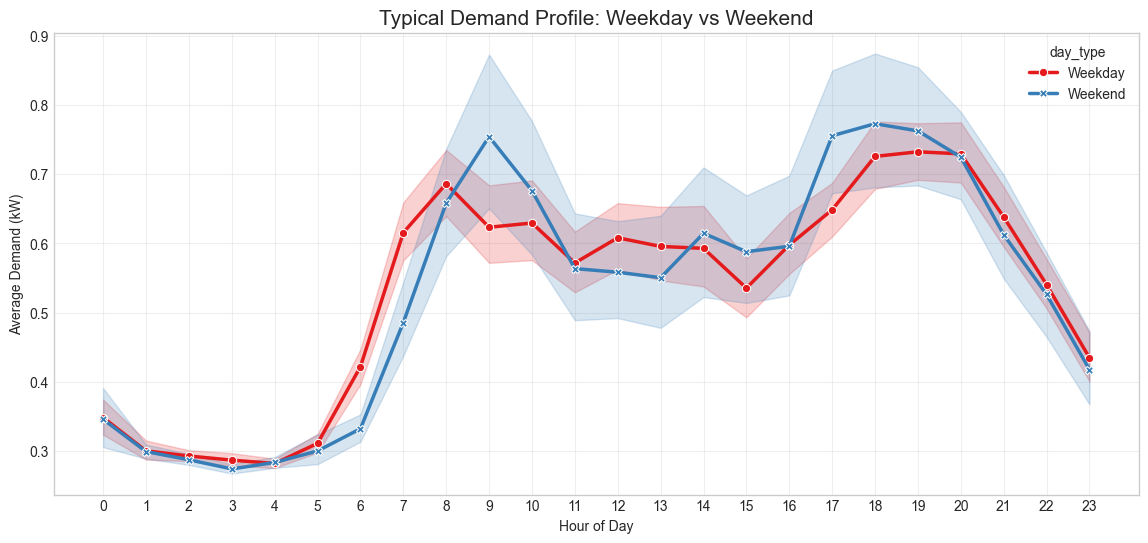

Gráfica 2 guardada: results/task6\typical_profile_season_heatmap.png


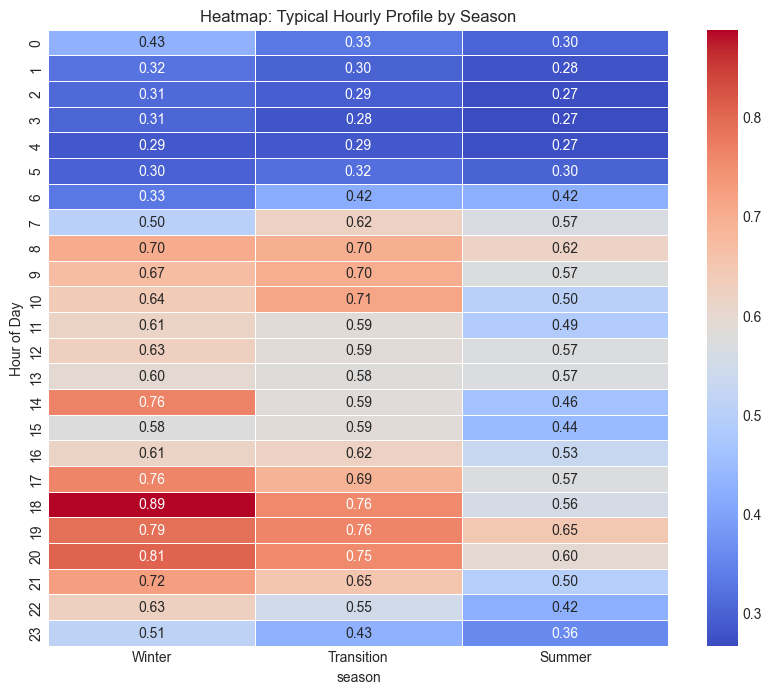


[METHODOLOGY EXPLANATION (Req 6.4)]
1. **Weekday vs Weekend:** We separated the data to highlight routine changes (e.g., waking up later on Sundays).
2. **Seasonality:** We grouped months into Winter/Summer to observe the impact of temperature/lighting.
3. **Calculation:** We used the Arithmetic Mean per hour to smooth out specific daily anomalies and find the 'typical' behavior.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os # Necesario para crear carpetas

# --- CELL 4: TYPICAL DEMAND PROFILES (REQ 6.3 & 6.4) ---
# Methodology: Group by hour (0-23) and calculate the mean.
# Breakdown: General, Day Type (Weekday/Weekend), and Season.

try:
    df_profile = df.copy()
    df_profile['hour'] = df_profile.index.hour
    df_profile['day_type'] = np.where(df_profile.index.dayofweek >= 5, 'Weekend', 'Weekday')

    # Define Seasons (Simplified for Northern Hemisphere)
    def get_season(month):
        if month in [12, 1, 2]: return 'Winter'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Transition' # Spring/Autumn
    df_profile['season'] = df_profile.index.month.map(get_season)

    # Definir directorio de salida una vez
    output_dir = 'results/task6'
    os.makedirs(output_dir, exist_ok=True)

    # =============================================
    # PLOT 1: Typical Daily Profile (Weekday vs Weekend)
    # =============================================
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df_profile, x='hour', y='demand', hue='day_type', style='day_type', 
                 markers=True, dashes=False, linewidth=2.5, palette='Set1')
    plt.title("Typical Demand Profile: Weekday vs Weekend", fontsize=15)
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Demand (kW)")
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24))

    # --- SAVE LOGIC PLOT 1 ---
    filename1 = 'typical_profile_weekday_weekend.png'
    save_path1 = os.path.join(output_dir, filename1)
    plt.savefig(save_path1, dpi=300, bbox_inches='tight')
    print(f"Gráfica 1 guardada: {save_path1}")
    # -------------------------

    plt.show()

    # =============================================
    # PLOT 2: Typical Profile by Season (Heatmap)
    # =============================================
    # Create a pivot table: Hour x Season
    pivot_season = df_profile.pivot_table(index='hour', columns='season', values='demand', aggfunc='mean')
    pivot_season = pivot_season[['Winter', 'Transition', 'Summer']] # Reorder columns

    plt.figure(figsize=(10, 8)) # Un poco más alto para que se vean bien los números
    sns.heatmap(pivot_season, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
    plt.title("Heatmap: Typical Hourly Profile by Season")
    plt.ylabel("Hour of Day")

    # --- SAVE LOGIC PLOT 2 ---
    filename2 = 'typical_profile_season_heatmap.png'
    save_path2 = os.path.join(output_dir, filename2)
    plt.savefig(save_path2, dpi=300, bbox_inches='tight')
    print(f"Gráfica 2 guardada: {save_path2}")
    # -------------------------

    plt.show()

    print("\n[METHODOLOGY EXPLANATION (Req 6.4)]")
    print("1. **Weekday vs Weekend:** We separated the data to highlight routine changes (e.g., waking up later on Sundays).")
    print("2. **Seasonality:** We grouped months into Winter/Summer to observe the impact of temperature/lighting.")
    print("3. **Calculation:** We used the Arithmetic Mean per hour to smooth out specific daily anomalies and find the 'typical' behavior.")

except Exception as e:
    print(f"Error generando los perfiles: {e}")